In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from datetime import datetime
import matplotlib.pyplot as plt
import os
import model as mod
import dataset
from dataset import plot_piano_roll
from pathlib import Path
import time

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

FS = 10  # Sampling frequency
BS = 64  # Batch size

In [16]:
 """Run main script."""
# Load midi files.
midi_list = [x for x in os.listdir(P / "data") if x.endswith('.mid')]
epochs = 10
st = 20
num_ts = 10

# All dataset
train_list = midi_list[0:165]
validation_list = midi_list[166:213]
test_list = midi_list[213:236]

# Small dataset
# train_list = midi_list[0:50]
# validation_list = midi_list[50:60]
# test_list = midi_list[61:65]

print("Train list:  ", train_list)
print("Validation list:  ", validation_list)
print("Test list:  ", test_list)


Train list:   ['alb_esp1.mid', 'alb_esp2.mid', 'alb_esp3.mid', 'alb_esp4.mid', 'alb_esp5.mid', 'alb_esp6.mid', 'alb_se1.mid', 'alb_se2.mid', 'alb_se4.mid', 'alb_se6.mid', 'alb_se8.mid', 'appass_1.mid', 'appass_3.mid', 'bach_846.mid', 'bach_847.mid', 'bach_850.mid', 'beethoven_hammerklavier_1.mid', 'beethoven_hammerklavier_2.mid', 'beethoven_hammerklavier_3.mid', 'beethoven_les_adieux_3.mid', 'beethoven_opus10_1.mid', 'beethoven_opus10_2.mid', 'beethoven_opus10_3.mid', 'beethoven_opus22_1.mid', 'beethoven_opus22_3.mid', 'beethoven_opus22_4.mid', 'beethoven_opus90_1.mid', 'beethoven_opus90_2.mid', 'bor_ps1.mid', 'bor_ps2.mid', 'bor_ps4.mid', 'bor_ps5.mid', 'bor_ps6.mid', 'bor_ps7.mid', 'brahms_opus117_1.mid', 'brahms_opus117_2.mid', 'brahms_opus1_2.mid', 'brahms_opus1_3.mid', 'brahms_opus1_4.mid', 'br_im2.mid', 'br_im5.mid', 'br_rhap.mid', 'burg_agitato.mid', 'burg_erwachen.mid', 'burg_geschwindigkeit.mid', 'burg_gewitter.mid', 'burg_perlen.mid', 'burg_quelle.mid', 'burg_spinnerlied.mid'

In [17]:
 # Build Keras model.
model = mod.build_model((st, 88), num_ts)
now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)
# Create generators.
train = dataset.DataGenerator(train_list, P / "data",  fs=FS)
validation = dataset.DataGenerator(validation_list, P / "data",  fs=FS)
test = dataset.DataGenerator(test_list, P / "data",  fs=FS)
train.build_dataset("training", step=st, t_step=num_ts)
validation.build_dataset("validation", step=st, t_step=num_ts)
test.build_dataset("test", step=st, t_step=num_ts)
print("Done")

Building training dataset (165 files)
Building validation dataset (47 files)
Building test dataset (22 files)


In [18]:
# Fit the model.
# model.fit(train.generate(limit=epochs), epochs=epochs,
#           steps_per_epoch=1,  shuffle=True,
#           validation_data=validation.generate(limit=epochs),
#           validation_steps=1,
#           callbacks=[logger, csv_logger])
start = time.time()
history = model.fit(x=train.dataset[0], y=train.dataset[1],
                    epochs=epochs, batch_size=BS, shuffle=True,
                    validation_data=(validation.dataset[0],
                                     validation.dataset[1]),
                    callbacks=[logger, csv_logger])
end = time.time()

Train on 355246 samples, validate on 143866 samples
Epoch 1/10
355246/355246 [==============================] - 30s 84us/sample - loss: 0.1063 - precision_4: 0.7112 - recall_4: 0.2600 - f1_t1: 0.4342 - f1_t10: 0.4342 - val_loss: 0.1102 - val_precision_4: 0.7907 - val_recall_4: 0.3462 - val_f1_t1: 0.3379 - val_f1_t10: 0.3379
Epoch 2/10
355246/355246 [==============================] - 28s 80us/sample - loss: 0.0951 - precision_4: 0.7958 - recall_4: 0.3781 - f1_t1: 0.5091 - f1_t10: 0.5091 - val_loss: 0.1096 - val_precision_4: 0.7962 - val_recall_4: 0.3853 - val_f1_t1: 0.3397 - val_f1_t10: 0.3397
Epoch 3/10
355246/355246 [==============================] - 31s 88us/sample - loss: 0.0939 - precision_4: 0.7982 - recall_4: 0.3955 - f1_t1: 0.5171 - f1_t10: 0.5171 - val_loss: 0.1107 - val_precision_4: 0.7987 - val_recall_4: 0.3974 - val_f1_t1: 0.3385 - val_f1_t10: 0.3385
Epoch 4/10
355246/355246 [==============================] - 31s 86us/sample - loss: 0.0932 - precision_4: 0.8004 - recall_4: 0

In [20]:
history.history

{'loss': [0.10631117609485252,
  0.09514820647697703,
  0.09385537132054121,
  0.09323163972975268,
  0.09282626144365973,
  0.09254889355795742,
  0.09235778269939378,
  0.0921965847838889,
  0.0920524429508408,
  0.0919326807044102],
 'precision_4': [0.7112217,
  0.7958038,
  0.7981786,
  0.8003651,
  0.80298215,
  0.8024291,
  0.8034702,
  0.8040025,
  0.8043872,
  0.8045792],
 'recall_4': [0.2600078,
  0.37811002,
  0.39546356,
  0.40204424,
  0.40495425,
  0.40903962,
  0.41077337,
  0.41252092,
  0.41367376,
  0.41465726],
 'f1_t1': [0.43415967,
  0.5091303,
  0.5171431,
  0.5198955,
  0.52236044,
  0.5228745,
  0.524315,
  0.52549446,
  0.525732,
  0.5263111],
 'f1_t10': [0.43415967,
  0.5091303,
  0.5171431,
  0.5198955,
  0.52236044,
  0.5228745,
  0.524315,
  0.52549446,
  0.525732,
  0.5263111],
 'val_loss': [0.11020115620002828,
  0.1096125235648107,
  0.1106776924520545,
  0.11092360164537882,
  0.11015629601343845,
  0.11110858760698836,
  0.110362058334126,
  0.112107480

In [21]:
# Evaluate the model.
print("Evaluation on test set:")
_, prec, rec, f1, f2 = model.evaluate(x=test.dataset[0],
                                  y=test.dataset[1],
                                  batch_size=BS)
# _, prec, rec, f1 = model.evaluate(test.generate(limit=epochs),
#                                   steps=1)

Evaluation on test set:
44697/44697 [==============================] - 2s 40us/sample - loss: 0.0979 - precision_4: 0.8041 - recall_4: 0.4146 - f1_t1: 0.2880 - f1_t10: 0.2880


Pred shape:  (44697, 880)
(44697, 88)
(44697, 20, 88) 





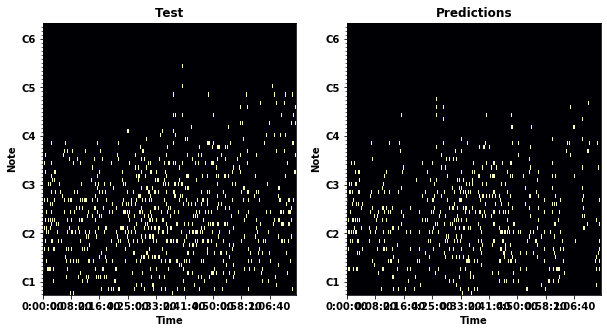

Training time:  297.2966299057007


In [22]:
predictions = model.predict(x=test.dataset[0])
print("Pred shape: ", predictions.shape)
predictions = predictions[:, 0:88]
print(predictions.shape)
print(test.dataset[0].shape, "\n\n\n")
test = test.dataset[0][:, 0, :]
predictions = dataset.transpose(predictions)
predictions = dataset.convert(predictions)
# test = test[:, 0, :]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_piano_roll(dataset.transpose(test), 21, 109, ax1, FS)
ax1.set_title('Test')

plot_piano_roll(predictions, 21, 109, ax2, FS)
ax2.set_title('Predictions')
plt.show()
print("Training time: ", (end-start))